# DINOv2 Image Embeddings Demo

This notebook demonstrates how to use DINOv2 to extract image embeddings and understand the output structure.

> **NOTE**: while we were preparing this notebook, DINOv3 came out. It is a slightly improved version of DINOv2 trained with more data and more compute. Everything we say here applies to DINOv3 as well. At the moment, however, DINOv3 is closed and access can only be obtained by registering to Huggingface and then providing your contact information to Meta/Facebook through their [huggingface organization](https://huggingface.co/facebook/dinov3-vits16-pretrain-lvd1689m).

In [1]:
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
from PIL import Image
from typing import List


def display_grid(images: List[Image.Image], *args, **kwargs):
    """
    Wrap the make_grid function from torchvision accepting PIL.Image instances
    instead of tensors. Every other arguments or keyword arguments is passed
    to make_grid.

    Images are going to be resized and center-cropped to 256x256 to fit
    in the grid.
    """
    transform = T.Compose(
        [
            T.Resize(256),  # resize shorter side to 256
            T.CenterCrop(256),  # center crop to 256x256 square
            T.ToTensor(),
        ]
    )

    tensors = [transform(img) for img in images]
    grid = torchvision.utils.make_grid(tensors, *args, **kwargs)
    _, sub = plt.subplots(dpi=300)
    sub.imshow(grid.permute(1, 2, 0))
    sub.axis("off")
    plt.show()

## 1. Load DINOv2 Model

We'll use the base DINOv2 model from Hugging Face.

In [2]:
from transformers import AutoImageProcessor, AutoModel


# Load DINOv2 model and processor
model_name = "facebook/dinov2-with-registers-base"

processor = AutoImageProcessor.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Set to evaluation mode
model.eval()

print(f"Model loaded: {model_name}")
print(f"Embedding dimension: {model.config.hidden_size}")

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Model loaded: facebook/dinov2-with-registers-base
Embedding dimension: 768


## 2. Load Sample Images

Let's load two similar images and one different image to demonstrate the embeddings.

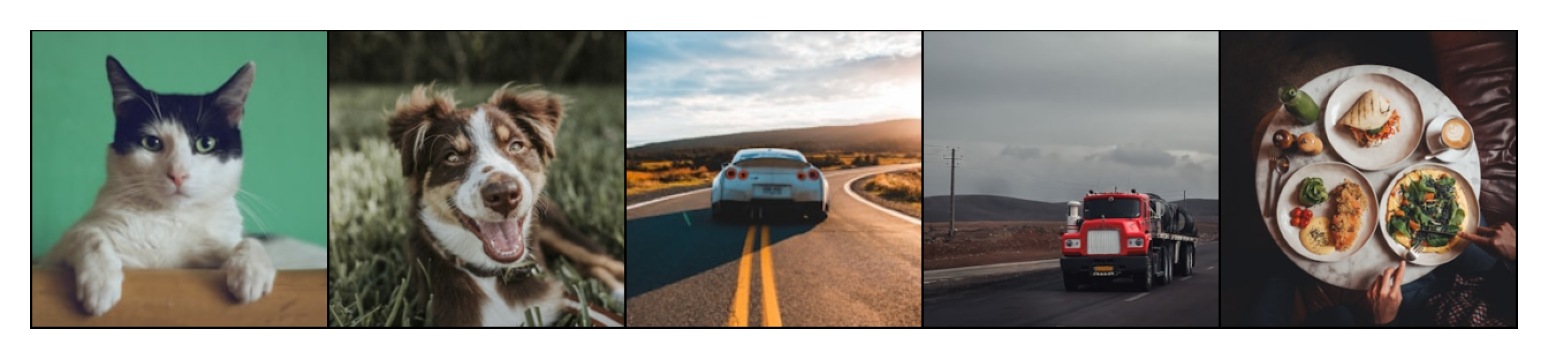

In [3]:
# Load sample images
image_list = {
    'cat': 'images/cat.jpg',
    'dog': 'images/dog.jpg', 
    'car': 'images/car.jpg',
    "truck": 'images/truck.jpg',
    "food": "images/food.jpg"
}

images = {}
for name, path in image_list.items():
    images[name] = Image.open(path)

display_grid(images.values(), nrow=5)

## 3. ViT: "An Image is Worth 16x16 words"

In the seminal paper which introduced the Vision Transformers ("An Image is Worth 16x16 words", Dosovitskiy et al 2020), the authors introduced the basic idea which permitted to apply transfomers to images.

An image gets divided into a grid of patches. The authors chose patches of 14 by 14 pixels and images of 224 by 224 pixels, which gave 16 patches per side (i.e., 16 x 16 = 256 total patches). Let's see how this work with a simple visualization:

facebook/dinov2-with-registers-base has a patch size of 14
The processor resizes the imags to 224 x 224 pixels
This means there are 16 patches per size (256 total patches)


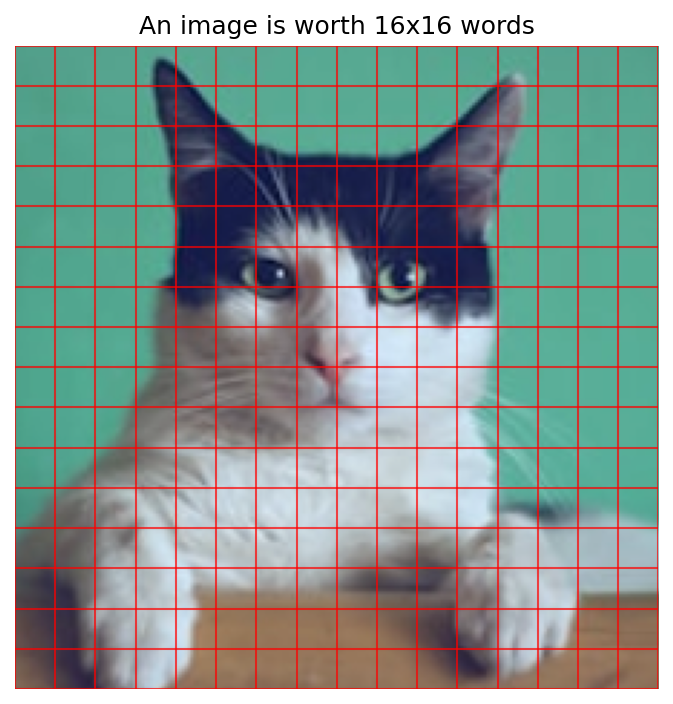

Each red square represents one patch that gets its own embedding vector!


In [46]:
# These numbers are specific to this "facebook/dinov2-with-registers-base" model
patch_size = model.config.patch_size

# Image size: this is determined by the processor,
# which among other things resizes the image to be square
# with a specific size
h, w = processor.crop_size['height'], processor.crop_size['width']

# Now given the h and the w, we can compute how many patches we have
# per side (remember, the image is square)
patches_per_side = h // patch_size

print(f"{model_name} has a patch size of {patch_size}")
print(f"The processor resizes the imags to {w} x {h} pixels")
print(f"This means there are {patches_per_side} patches per size ({patches_per_side**2} total patches)")

# Visualize the patch structure
fig, sub = plt.subplots(dpi=150)

# Preprocessed image
preproc_image = processor(images['cat'])['pixel_values'][0].transpose((1, 2, 0))
preproc_image -= preproc_image.min()
preproc_image /= preproc_image.max()

# Grid overlay showing patches
sub.imshow(preproc_image, extent=[0, 224, 224, 0])
sub.set_title(f'An image is worth {patches_per_side}x{patches_per_side} words')

# Draw grid lines
for i in range(patches_per_side + 1):
    x = i * patch_size
    sub.axvline(x, color='red', linewidth=1, alpha=0.7)
    sub.axhline(x, color='red', linewidth=1, alpha=0.7)

sub.axis('off')
plt.tight_layout()
plt.show()

print("Each red square represents one patch that gets its own embedding vector!")

Normally Vision Transformers also add a class token (CLS token) at the beginning of the sequence, which is learned during training. For example, for DINOv2 through HuggingFace transformers, we can print the initial 50 numbers for the CLS token like this:

In [47]:
print(f"The CLS token has shape {model.embeddings.cls_token.shape[-1]}")
model.embeddings.cls_token[0][0][:50]

The CLS token has shape 768


tensor([-0.0002, -0.0022, -0.0172,  0.0019, -0.0003,  0.0050,  0.0042, -0.0112,
        -0.0240, -0.0059,  0.0008,  0.0107, -0.0083, -0.0117,  0.0017, -0.0001,
         0.0031, -0.0174,  0.0003,  0.0050, -0.0152, -0.0071,  0.0070, -0.0384,
         0.0077, -0.0127, -0.0002, -0.0021,  0.0061, -0.0023,  0.0072,  0.0092,
         0.0005, -0.0179, -0.0132, -0.0193,  0.0037,  0.0005, -0.0027, -0.0040,
        -0.0194, -0.0003, -0.0066,  0.0003,  0.0133, -0.0065,  0.0023,  0.0063,
         0.0008,  0.0020], grad_fn=<SliceBackward0>)

This initial CLS token gets transformed through the self-attention mechanism while it travels through the Transformer model. In these self-attention interactions it accumulates knowledge from all the patch tokens. When it outputs the transformer, it contains the most meaningful semantic information about the image.

### Register tokens

In recent years it has been discovered that self-supervised transformers like DINOv2 benefit from additional "scratch space", i.e., additional learned tokens just like the CLS token where the model can store information during training. These are called register tokens. They are useful during training but then discarded during inference. We can see that the model we are using has 4 of them, each of length 768 just like the CLS token:

In [48]:
model.embeddings.register_tokens.shape[1:]

torch.Size([4, 768])

## 4. Extract DINOv3 Embeddings

Now let's extract embeddings and understand the output structure:

- **CLS Token**: Global image representation (like a summary of the whole image)
- **Register Tokens**: scratch space, useful during training, discarded during inference
- **Patch Embeddings**: Local features from different parts of the image

In [49]:
import torch


def get_embeddings(batch: List[Image.Image]):
    """Extract DINOv3 embeddings from an image"""
    # Preprocess image
    inputs = processor(images=batch, return_tensors="pt")

    w, h = inputs['pixel_values'].shape[2:]
    print(f"Preprocessing resized each image to {w} by {h}")
    
    # Get model output
    with torch.no_grad():
        outputs = model(**inputs)
        
    # Extract embeddings
    last_hidden_states = outputs[0]
    
    # First token is CLS token (global representation)
    cls_tokens = last_hidden_states[:, 0, :].numpy()

    # Register tokens are scratch space used during training but should be discarded
    # at inference time
    num_register_tokens = model.config.num_register_tokens
    register_tokens = last_hidden_states[:, 1: 1 + num_register_tokens, :].numpy()
    
    # Remaining tokens are patch embeddings (local features)
    patch_embeddings = last_hidden_states[:, 1 + num_register_tokens:, :].numpy()
    
    return cls_tokens, register_tokens, patch_embeddings

cls_tokens, register_tokens, patch_embeddings = get_embeddings(list(images.values()))

Preprocessing resized each image to 224 by 224


Ok, now let's do some math and see what we should expect:

1. DINOv2 Base (the model we are using) has an embedding dimension of 768. So we should have a CLS token with shape [768] for each image, so the shape of `cls_tokens` should be [3, 768] (because we have 3 images in our batch)
2. We should also have the patch embeddings of dimension 768 each. But how many should we have? The ViT-Base transformer is a ViT/14 transformer, i.e., it divides the image in a grid where each patch is 14 by 14 pixels. Since the pre-processor resizes the images to 224 by 224, we should have (224 / 14)**2 = 256 patch embeddings.
3. The latest versions of DINOv2 add also "register tokens", which are additional tokens similar to the CLS token that act as dedicated "scratch space" or computational buffers during training. They provide the model with extra capacity to store intermediate computations and global information. They are learned during training but are typically discarded during inference for downstream tasks, having served their purpose of keeping the patch token representations clean and semantically meaningful. This version of DINOv2 has 4 register tokens

Let's see if this is true:

In [50]:
print(f"Shape of the CLS tokens: {cls_tokens.shape}")
print(f"Shape of the register tokens: {register_tokens.shape}")
print(f"Number of patch embeddings for each image: {patch_embeddings.shape}")

Shape of the CLS tokens: (5, 768)
Shape of the register tokens: (5, 4, 768)
Number of patch embeddings for each image: (5, 256, 768)


Make sure you understand these numbers now! 

> **NOTE**: when we talk about "embeddings" obtained with a ViT like DINOv2, we usually mean the CLS tokens!

## 5. Comparing Similar Images

Now let's see if similar images (two cats) have more similar CLS tokens than different images (cat vs dog).

/Users/giacomov/develop/cd13331-multimodal/l2/demos/3-dinov3/.venv/lib/python3.12/site-packages/sklearn/metrics/_plot/confusion_matrix.py:175: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  text_cm = format(cm[i, j], values_format)


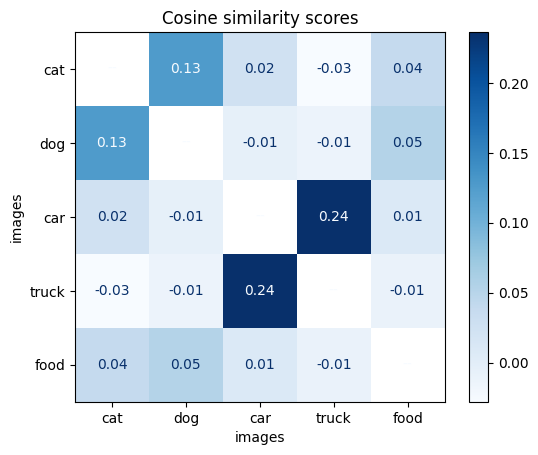

In [51]:
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay

def cosine_similarity_matrix(embeddings):
    # Normalize each embedding vector
    norms = np.linalg.norm(embeddings, axis=1, keepdims=True)
    normalized_embeddings = embeddings / norms
    
    # Compute similarity matrix
    return np.dot(normalized_embeddings, normalized_embeddings.T)

self_similarity_matrix = cosine_similarity_matrix(cls_tokens)

# Remove the diagonal, which is obviously one
cmap = plt.cm.Blues.copy()
cmap.set_bad('white')  # or 'lightgray'

cm_masked = np.ma.masked_where(self_similarity_matrix >= 0.99, self_similarity_matrix)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_masked, display_labels=list(images.keys()))
fig = disp.plot(cmap=cmap, values_format='.2f')
fig.ax_.set_title('Cosine similarity scores')
fig.ax_.set_xlabel("images")
fig.ax_.set_ylabel("images")
plt.show()

## 6. Note on the use of DINOv2

While here for simplicity we have used DINOv2 embeddings for image similarity search, in practice DINOv2 is much more often used as a starting point for classification, segmentation or object detection tasks (as well as others). With a small labeled dataset, you can keep the DINOv2 transformer frozen and you can train a lightweight head on top, which starts from the embeddings (and the patch embeddings in the case of segmentation or object detection) and give you the desired output. The DINOv2 backbone offers you a very meaningful representation, so you need very little data to get good performance.


In [1]:
import torch
import evaluate
from datasets import load_dataset, Features, ClassLabel, Image
from transformers import AutoImageProcessor, AutoModelForImageClassification, TrainingArguments, Trainer
import numpy as np

device = torch.device("mps")

# Step 1: Load the dataset
# We'll load a smaller subset for demonstration purposes to make it faster.
# For full training, remove the split argument.
dataset = load_dataset("enterprise-explorers/oxford-pets", split="train")

# For binary classification, we'll use the 'dog' column
# Create binary labels: 0 for False (not dog), 1 for True (dog)
def convert_dog_to_binary(example):
    example['labels'] = 1 if example['dog'] else 0
    return example

# Apply the conversion and remove the original columns we don't need
dataset = dataset.map(convert_dog_to_binary)
dataset = dataset.remove_columns(['label', 'dog'])  # Remove original columns
class_label_feature = ClassLabel(names=["not_dog", "dog"])
dataset = dataset.cast_column('labels', class_label_feature)

dataset = dataset.train_test_split(test_size=0.3, seed=42, stratify_by_column="labels")

# Create label mappings for binary classification
labels = ["not_dog", "dog"]  # 0: not_dog, 1: dog
label2id = {label: i for i, label in enumerate(labels)}
id2label = {i: label for i, label in enumerate(labels)}

# Step 2: Load the DINOv2 pre-trained model and processor
model_name = "facebook/dinov2-base"
image_processor = AutoImageProcessor.from_pretrained(model_name, use_fast=True)
model = AutoModelForImageClassification.from_pretrained(
    model_name,
    num_labels=2,  # Binary classification
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True, # Allows the classification head to be reinitialized
).to(device)

# Freeze the DINOv2 backbone
for param in model.dinov2.parameters():
    param.requires_grad = False

# Step 3: Define data preprocessing function
# The function will resize the images and convert them to PyTorch tensors.
def preprocess_dataset(examples):
    # 'pixel_values' is the standard input name for ViT-based models
    examples["pixel_values"] = image_processor(examples["image"], return_tensors="pt").pixel_values
    return examples

# Apply the preprocessing function to the entire dataset
# We use `map` to pre-process the data and remove the original 'image' column
processed_dataset = dataset.map(
    preprocess_dataset,
    batched=True,
    remove_columns=['image'],
)

# Step 4: Set up the metric computation
# We'll use accuracy as the evaluation metric, but you might also want to add precision, recall, F1
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    # The predictions are logits, so we take the argmax to get the predicted class
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

# Step 5: Configure training arguments
training_args = TrainingArguments(
    output_dir="./dinov2-dog-detection-finetuned",
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    num_train_epochs=3,
    save_steps=1000,
    eval_strategy="epoch",
    logging_steps=100,
    learning_rate=5e-5,
    fp16=False,  # Use bf16 instead for MPS
    bf16=True,   # Better mixed precision for MPS
    dataloader_num_workers=4,  # Parallel data loading
    dataloader_pin_memory=True
)

# Step 6: Create the Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=processed_dataset["train"],
    eval_dataset=processed_dataset["test"],
    compute_metrics=compute_metrics,
)

# Step 7: Start the training!
print("Starting training...")
trainer.train()

# Step 8: Save the fine-tuned model
trainer.save_model("./dinov2-dog-detection-finetuned")
print("Training complete and model saved.")



Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Some weights of Dinov2ForImageClassification were not initialized from the model checkpoint at facebook/dinov2-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.378099,0.840325
2,No log,0.233217,0.938656
3,0.393600,0.197621,0.958051


Training complete and model saved.
